In [ ]:
#https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
#!pip install graphviz
#!conda install --yes -c conda-forge graphviz

# Minimal example to get `dask.distributed` working

* No `dask_geopandas` installed in `dask.distributed`...will have to ask Andrew. For now, test `dask.dataframe` only.
* Move all functions into this notebook to simplify for now.
* Read in multiple tabular datasets, merge, and do aggregation.
* Get task graph loaded (`bus_service_utils` has the `pip` and `conda` requirements)
* Can we test `dask.delayed` and `dask futures`?

In [3]:
import dask.dataframe as dd
import pandas as pd

from dask.distributed import Client

analysis_date = "2022-10-12"
RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/cached_views/'

In [4]:
def import_data(itp_id, date):
    stop_times = dd.read_parquet(
                f"{RT_GCS}st_{itp_id}_{date}.parquet")
    trips = dd.read_parquet(
        f"{RT_GCS}trips_{itp_id}_{date}.parquet")
    
    return stop_times, trips

In [5]:
def categorize_time_of_day(value: int ) -> str:
    if isinstance(value, int):
        hour = value
    if hour < 4:
        return "Owl"
    elif hour < 7:
        return "Early AM"
    elif hour < 10:
        return "AM Peak"
    elif hour < 15:
        return "Midday"
    elif hour < 20:
        return "PM Peak"
    else:
        return "Evening"

In [6]:
def merge_stop_times_to_trips(stop_times: dd.DataFrame, 
                          trips: dd.DataFrame) -> dd.DataFrame:   
    shape_id_cols = ["calitp_itp_id", "shape_id"]

    merged = dd.merge(
        stop_times,
        trips[shape_id_cols + ["trip_id"]].drop_duplicates(),
        on = ["calitp_itp_id", "trip_id"]
    )
    
    # Map to time-of-day
    stop_times_binned = merged.assign(
        time_of_day=merged.apply(
            lambda x: categorize_time_of_day(x.departure_hour), axis=1, 
            meta=('time_of_day', 'str'))
    )
    
    # Calculate the number of arrivals by time-of-day
    arrivals = (stop_times_binned.groupby(shape_id_cols + ["time_of_day"])
          .agg({"stop_id": "count"})
            .reset_index()
         )
    
    return arrivals

In [7]:
client = Client("dask-scheduler.dask.svc.cluster.local:8786")
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.2.0          | 2.1.0          | 2.1.0          |
| dask        | 2022.05.2      | 2022.8.0       | 2022.8.0       |
| distributed | 2022.5.2       | 2022.8.0       | 2022.8.0       |
| numpy       | 1.23.3         | 1.23.1         | 1.23.1         |
| pandas      | 1.5.0          | 1.4.3          | 1.4.3          |
| python      | 3.10.6.final.0 | 3.8.13.final.0 | 3.8.13.final.0 |
+-------------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.96.3.216:8786' processes=3 threads=6, memory=46.91 GiB>

Show task graph for just 1 operator.

* low-level: `.visualize()` 
* high-level: `.dask.visualize()`

In [8]:
def import_data_combined(date):
    RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/'
    stop_times = dd.read_parquet(f"{RT_GCS}st_{date}.parquet")
    trips = dd.read_parquet(f"{RT_GCS}trips_{date}.parquet")
    
    return stop_times, trips

In [9]:
all_stop_times, all_trips = import_data_combined(analysis_date)

In [10]:
all_stop_times = all_stop_times.repartition(npartitions=5)
all_trips = all_trips.repartition(npartitions=5)

In [11]:
merged = merge_stop_times_to_trips(all_stop_times, all_trips)

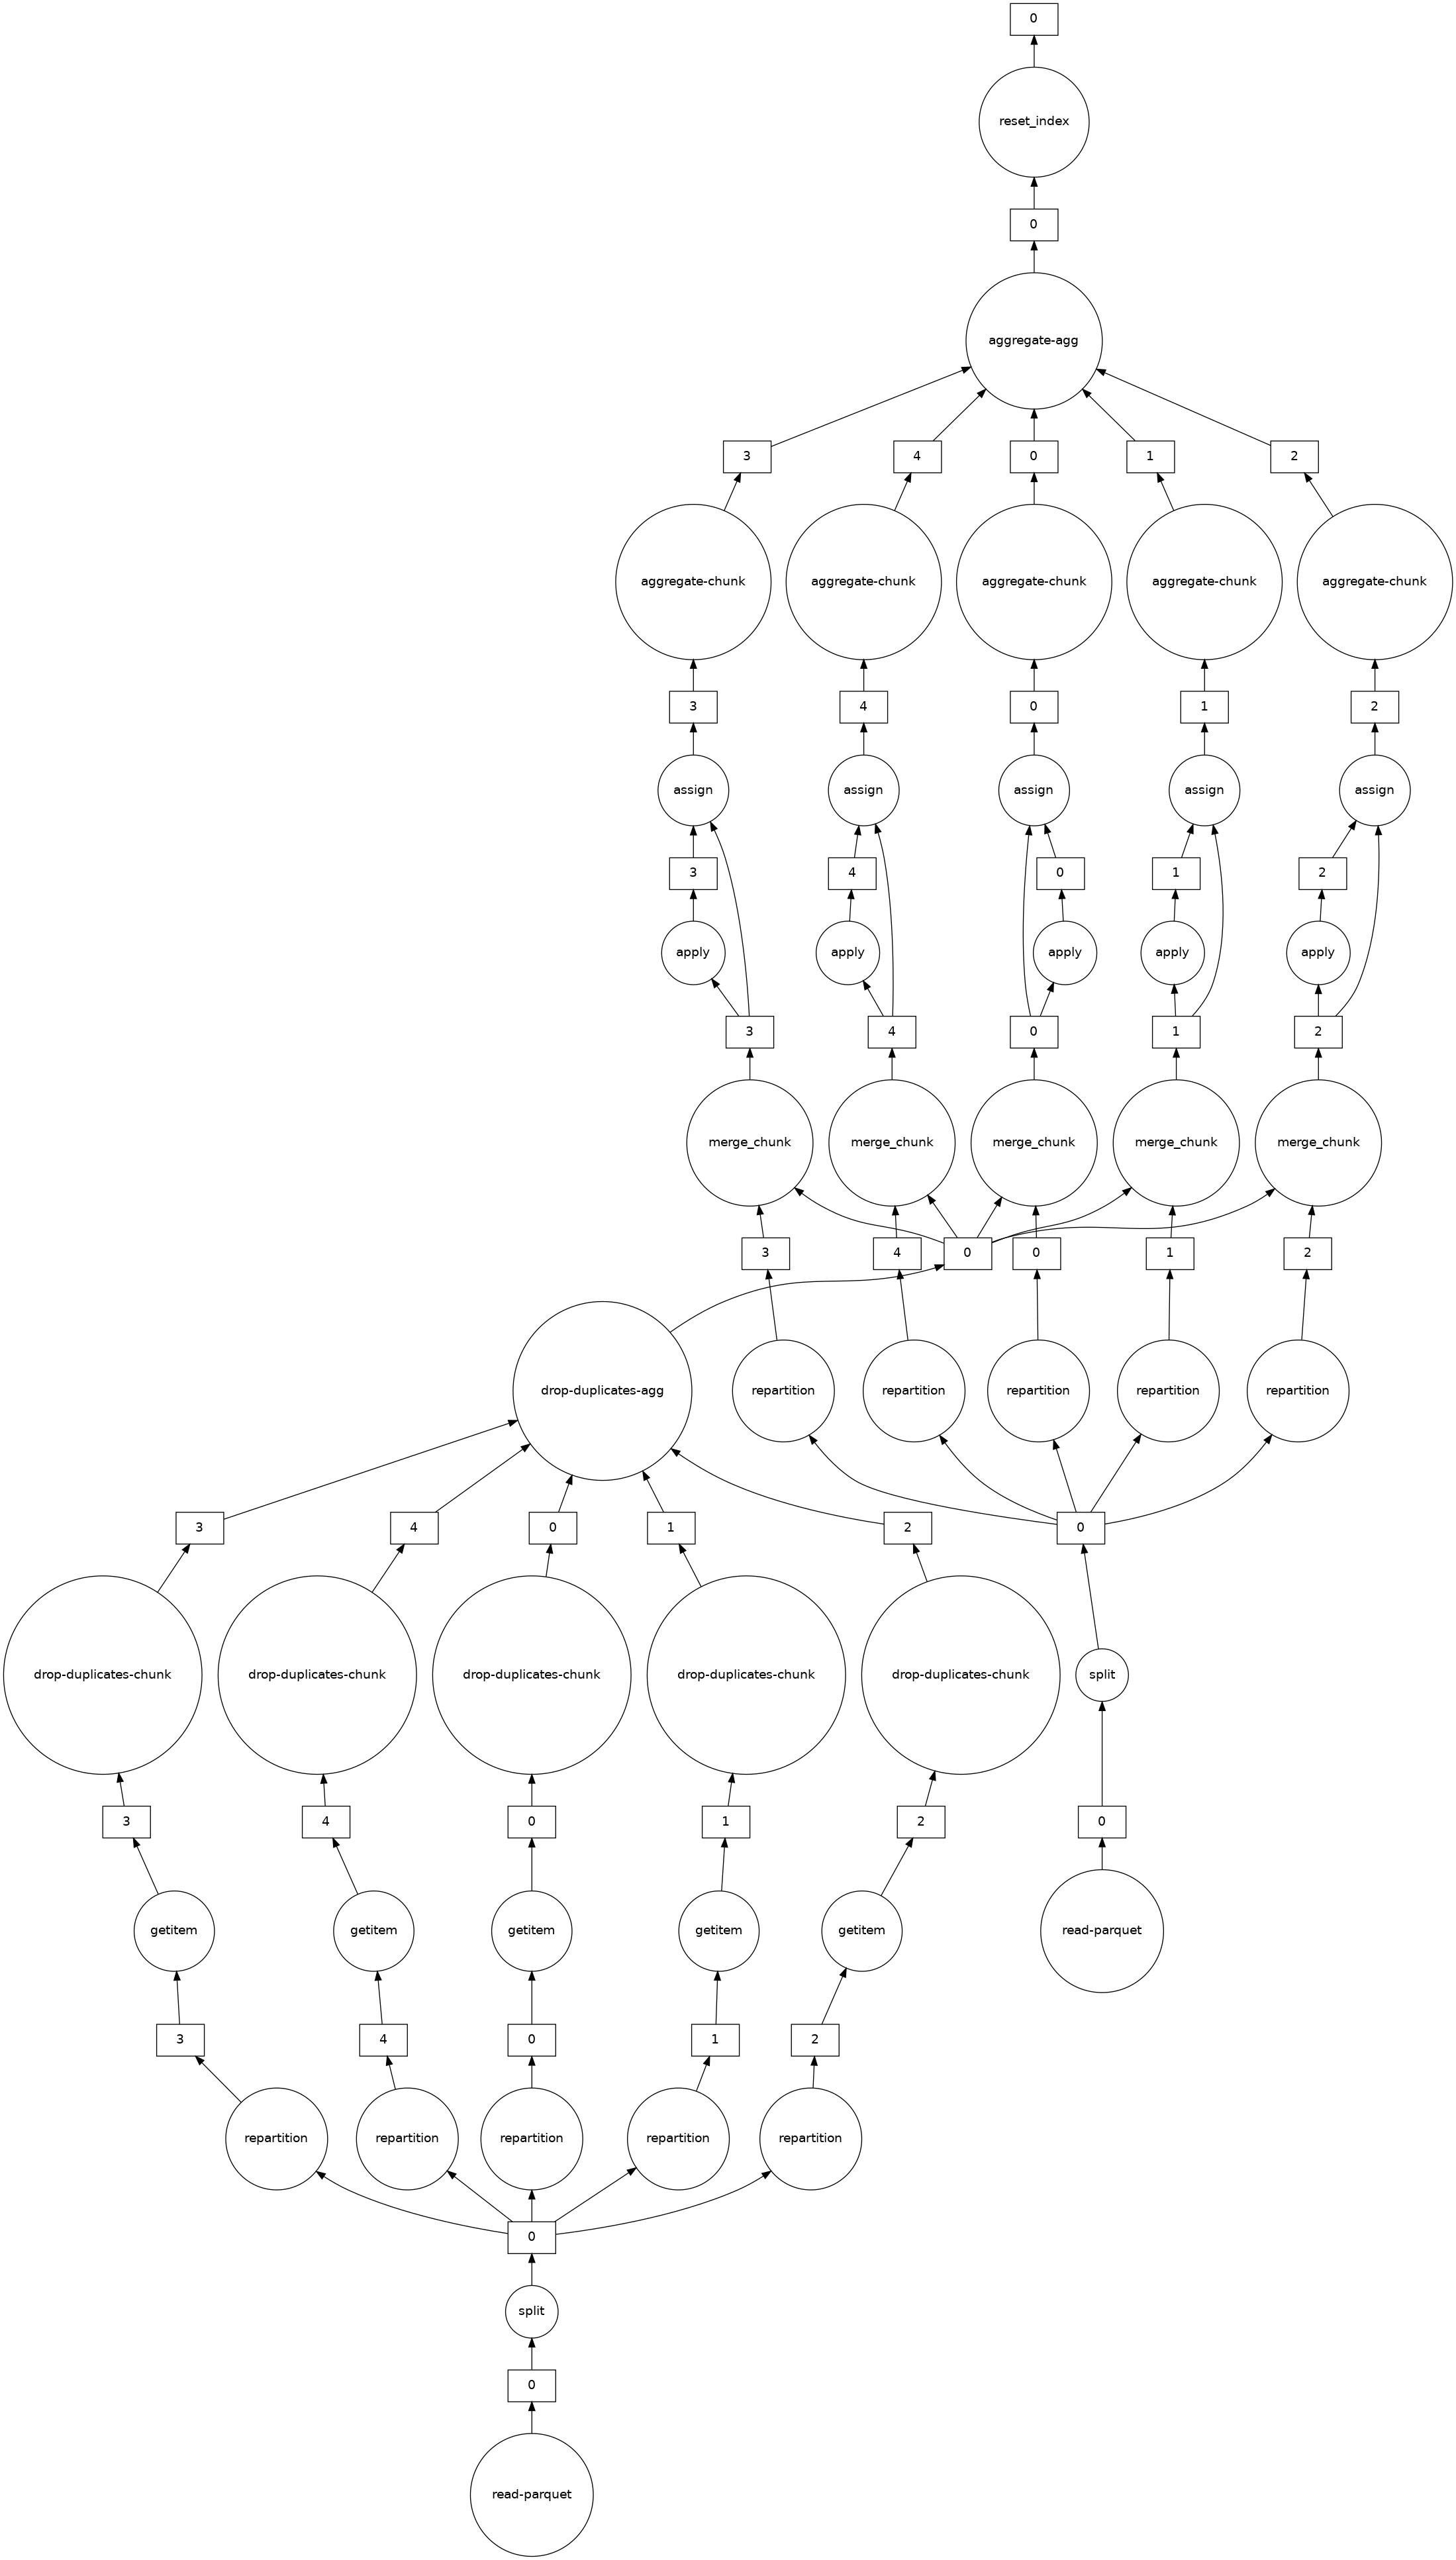

In [12]:
# Low-level graph
merged.visualize(optimize_graph=True)

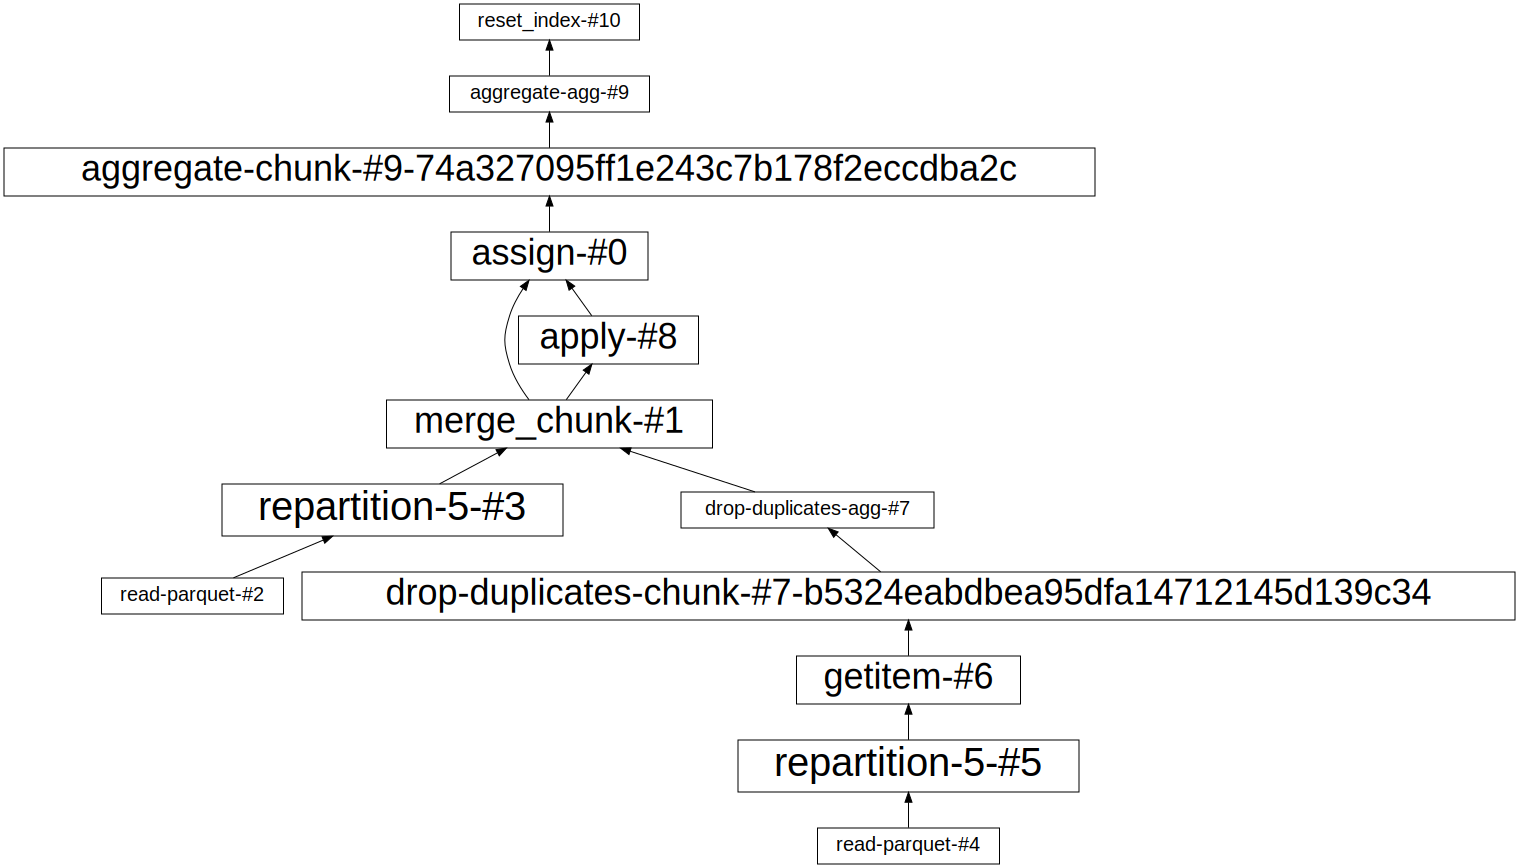

In [13]:
# High-level graph
merged.dask.visualize()

In [ ]:
# Serialization issue comes up when compute() is called
# to turn dask.dataframe into pandas df...and here, to create a list of 1 value
merged[merged.calitp_itp_id==182].calitp_itp_id.unique().compute()

2022-10-24 17:17:24,499 - distributed.protocol.pickle - INFO - Failed to deserialize b'\x80\x04\x95L\x03\x00\x00\x00\x00\x00\x00\x8c\x15distributed.scheduler\x94\x8c\x0cKilledWorker\x94\x93\x94\x8cX(\'aggregate-chunk-dc09731427de93da96117ea66965b5ce-74a327095ff1e243c7b178f2eccdba2c\', 3)\x94h\x00\x8c\x0bWorkerState\x94\x93\x94)\x81\x94N}\x94(\x8c\x07address\x94\x8c\x17tcp://10.96.11.27:45221\x94\x8c\x03pid\x94M\xbe\x01\x8c\x04name\x94\x8c\x17tcp://10.96.11.27:45221\x94\x8c\x08nthreads\x94K\x02\x8c\x0cmemory_limit\x94\x8a\x05\x00p\xae\xe8\x03\x8c\x0flocal_directory\x94\x8c&/tmp/dask-worker-space/worker-cps32zlg\x94\x8c\x08services\x94}\x94\x8c\tdashboard\x94MV"s\x8c\x08versions\x94}\x94\x8c\x05nanny\x94\x8c\x17tcp://10.96.11.27:35095\x94\x8c\x06status\x94\x8c\x10distributed.core\x94\x8c\x06Status\x94\x93\x94\x8c\x06closed\x94\x85\x94R\x94\x8c\x05_hash\x94\x8a\x083/\t\x1b0\xeb\xc5\n\x8c\x06nbytes\x94K\x00\x8c\toccupancy\x94K\x00\x8c\x15_memory_unmanaged_old\x94K\x00\x8c\x19_memory_unmana

In [ ]:
#merged.to_parquet("gs://calitp-analytics-data/data-analyses/dask_test/test.parquet")